In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

%matplotlib inline

Network Model

In [2]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer=nn.Sequential(
            nn.Linear(28*28,256,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(256,256,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1,bias=True),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        return self.layer(x)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.layer=nn.Sequential(
            nn.Linear(100,256,bias=True),
            nn.ReLU(),
            nn.Linear(256,256,bias=True),
            nn.ReLU(),
            nn.Linear(256,28*28,bias=True),
            nn.Tanh()
        )
    def forward(self,x):
        return self.layer(x)

Train

Epoch 0, Gen_cost = 1.373016343, Dis_cost = 1.104432933


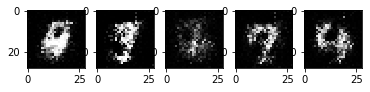

Epoch 1, Gen_cost = 1.315811474, Dis_cost = 1.094695226


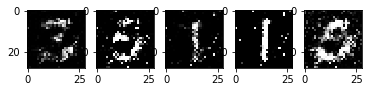

Epoch 2, Gen_cost = 1.196751290, Dis_cost = 1.127254701


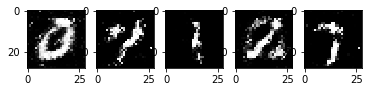

Epoch 3, Gen_cost = 1.179134137, Dis_cost = 1.128438679


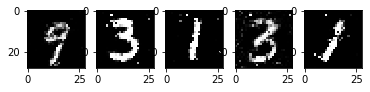

Epoch 4, Gen_cost = 1.152588416, Dis_cost = 1.143845198


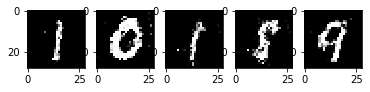

Epoch 5, Gen_cost = 1.121946700, Dis_cost = 1.160864078


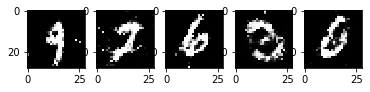

Epoch 6, Gen_cost = 1.101832982, Dis_cost = 1.170324283


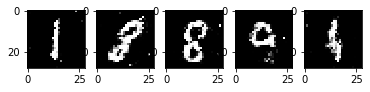

Epoch 7, Gen_cost = 1.081517622, Dis_cost = 1.183360159


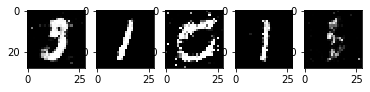

Epoch 8, Gen_cost = 1.077531263, Dis_cost = 1.185907100


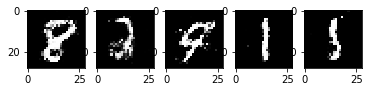

Epoch 9, Gen_cost = 1.092345248, Dis_cost = 1.178560008


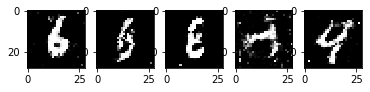

Epoch 10, Gen_cost = 1.095550368, Dis_cost = 1.174946099


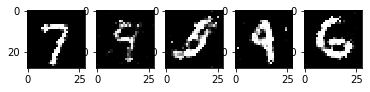

Epoch 11, Gen_cost = 1.104215400, Dis_cost = 1.178475677


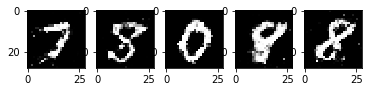

Epoch 12, Gen_cost = 1.114377582, Dis_cost = 1.166447677


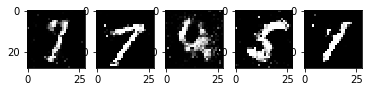

Epoch 13, Gen_cost = 1.132828556, Dis_cost = 1.159253224


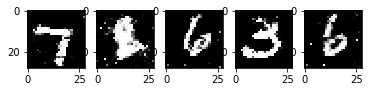

Epoch 14, Gen_cost = 1.139916318, Dis_cost = 1.154720671


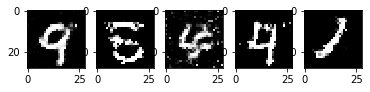

Epoch 15, Gen_cost = 1.152442150, Dis_cost = 1.142409606


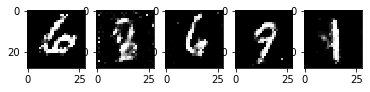

Epoch 16, Gen_cost = 1.176347409, Dis_cost = 1.128488867


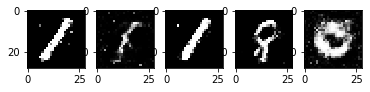

Epoch 17, Gen_cost = 1.185836599, Dis_cost = 1.125576562


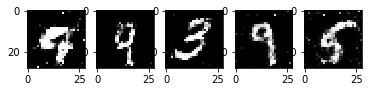

Epoch 18, Gen_cost = 1.194619976, Dis_cost = 1.120582389


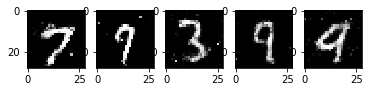

Epoch 19, Gen_cost = 1.199739032, Dis_cost = 1.121059636


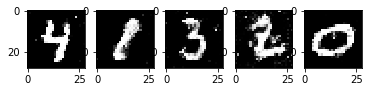

Epoch 20, Gen_cost = 1.215629376, Dis_cost = 1.110555855


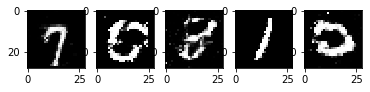

Epoch 21, Gen_cost = 1.223717545, Dis_cost = 1.110670483


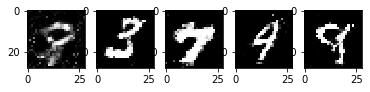

Epoch 22, Gen_cost = 1.220332867, Dis_cost = 1.109518162


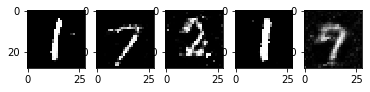

Epoch 23, Gen_cost = 1.227254014, Dis_cost = 1.105623984


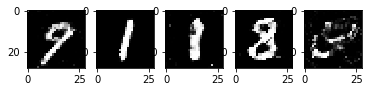

Epoch 24, Gen_cost = 1.221713253, Dis_cost = 1.107436524


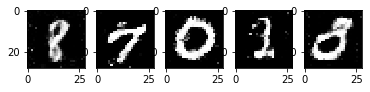

Epoch 25, Gen_cost = 1.240909758, Dis_cost = 1.099515183


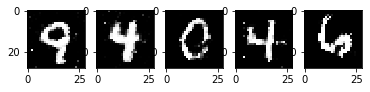

Epoch 26, Gen_cost = 1.252327711, Dis_cost = 1.095146219


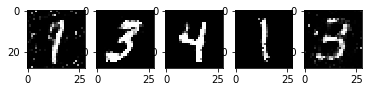

Epoch 27, Gen_cost = 1.258351005, Dis_cost = 1.089015454


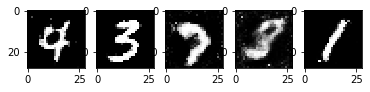

Epoch 28, Gen_cost = 1.270288870, Dis_cost = 1.086182866


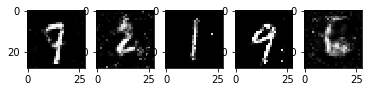

Epoch 29, Gen_cost = 1.265904968, Dis_cost = 1.085365393


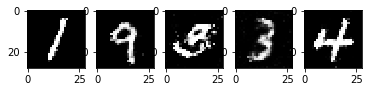

In [9]:
device='cuda' if torch.cuda.is_available() else 'cpu'

trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])

mnist_train=dsets.MNIST(root='MNIST_data/',train=True,transform=trans,download=True)
mnist_test=dsets.MNIST(root='MNIST_data/',train=False,transform=trans,download=True)

train_loader=DataLoader(dataset=mnist_train,shuffle=True,batch_size=64)

NetG=Generator().to(device)
NetD=Discriminator().to(device)

#NetG.load_state_dict(torch.load('param/GAN_G.pth'))
#NetD.load_state_dict(torch.load('param/GAN_D.pth'))

optim_G=optim.Adam(NetG.parameters(),lr=0.001,betas=(0.5,0.999))
optim_D=optim.Adam(NetD.parameters(),lr=0.001,betas=(0.5,0.999))

criterion=nn.BCELoss()

for epoch in range(30):
    avg_G,avg_D=0.0,0.0
    for X,Y in train_loader:
        X,Y=X.view(X.size(0),-1).to(device),Y.to(device)
        
        real_label=torch.ones(X.size(0),1).to(device)
        fake_label=torch.zeros(X.size(0),1).to(device)        
        rand=torch.randn(X.size(0),100).to(device)
        
        ### Discriminator Loss ###        
        real_output=NetD(X)
        fake_output=NetD(NetG(rand))
        
        cost_D_Real=criterion(real_output,real_label)
        cost_D_Fake=criterion(fake_output,fake_label)
                              
        cost_D=cost_D_Real+cost_D_Fake
        
        optim_D.zero_grad()
        cost_D.backward()        
        optim_D.step()        
        
        ### Generator Loss ###
        rand=torch.randn(X.size(0),100).to(device)
        Gen_img=NetG(rand)      
        
        cost_G=criterion(NetD(Gen_img),real_label)
        
        optim_G.zero_grad()
        cost_G.backward()        
        optim_G.step()
        
        avg_D+=cost_D.item()
        avg_G+=cost_G.item()
    else:
        avg_D/=len(train_loader)
        avg_G/=len(train_loader)
        torch.save(NetG.state_dict(),'param/GAN_G.pth')
        torch.save(NetD.state_dict(),'param/GAN_D.pth')
        print('Epoch {}, Gen_cost = {:.9f}, Dis_cost = {:.9f}'.format(epoch,avg_G,avg_D))
        
        fig,(axes)=plt.subplots(1,5)
        for i,ax in enumerate(axes):
            ax.imshow(Gen_img[i].view(28,28).detach().cpu().numpy(),cmap='gray')
        plt.show()